包含用CosFace、SphereFace以及ArcFace的Loss函数训练MINST数据集的代码，顺便对TensorFlow练练手

环境是TensorFlow 2.8.0

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


In [2]:
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [11]:
class custom_layer_softmax(tf.keras.layers.Layer):
    def __init__(self, output_nums):
        super(custom_layer_softmax, self).__init__()
        self.output_nums = output_nums
        #self.D =  tf.keras.layers.Dense(10)
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.output_nums),
            initializer="random_normal",
            trainable=True,
        )
        
        self.b = self.add_weight(
            shape=(self.output_nums,),
            initializer=tf.zeros_initializer(),
            trainable=True,
        )
    
    # 为了适应下面的类，加入一个多余的参数
    def call(self, y_pred, y_true):
        y_pred = tf.matmul(y_pred, self.w)+self.b
        return tf.math.softmax(y_pred)

class custom_layer_arcface(tf.keras.layers.Layer):
    def __init__(self, output_nums):
        super(custom_layer_arcface, self).__init__()
        self.output_nums = output_nums
        self.m = tf.constant(0.15)
        
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.output_nums),
            initializer="random_normal",
            trainable=True,
        )    
        
    def call(self, y_pred, y_true):
        _x = tf.math.l2_normalize(y_pred, 1)
        _w = tf.transpose(tf.math.l2_normalize(tf.transpose(self.w), 1))
        out = tf.matmul(_x, _w)
        y_true = tf.one_hot(y_true, self.output_nums)
        orig_cos_theta = tf.reduce_sum((y_true*out), 1, True)
        
        #arc(-1) arc(1)的导数是无穷大，所以要避免。否则会出现NaN，查了好久
        orig_cos_theta = tf.clip_by_value(orig_cos_theta, -1+0.00001, 1-0.00001)
        theta = tf.acos(orig_cos_theta)
        cos_theta = tf.cos(theta + self.m)
        out += (cos_theta - orig_cos_theta)  * y_true
        out = tf.norm(y_pred, 2, 1, True)*out
        return tf.math.softmax(out)

    
    
class custom_layer_cosface(tf.keras.layers.Layer):
    def __init__(self, output_nums):
        super(custom_layer_cosface, self).__init__()
        self.output_nums = output_nums
        self.m = tf.constant(0.1)
        
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.output_nums),
            initializer="random_normal",
            trainable=True,
        )    
        
    def call(self, y_pred, y_true):
        _x = tf.math.l2_normalize(y_pred, 1)
        _w = tf.transpose(tf.math.l2_normalize(tf.transpose(self.w), 1))
        out = tf.matmul(_x, _w)
        y_true = tf.one_hot(y_true, self.output_nums)
        out -= self.m  * y_true
        out = tf.norm(y_pred, 2, 1, True)*out
        return tf.math.softmax(out)
    

class custom_layer_sphereface(tf.keras.layers.Layer):
    def __init__(self, output_nums):
        super(custom_layer_sphereface, self).__init__()
        self.output_nums = output_nums
        self.m = tf.constant(2.)
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.output_nums),
            initializer="random_normal",
            trainable=True,
        )    
        
    def call(self, y_pred, y_true):
        _x = tf.math.l2_normalize(y_pred, 1)
        _w = tf.transpose(tf.math.l2_normalize(tf.transpose(self.w), 1))
        out = tf.matmul(_x, _w)
        y_true = tf.one_hot(y_true, self.output_nums)
        orig_cos_theta = tf.reduce_sum((y_true*out), 1, True)
        
        #arc(-1) arc(1)的导数是无穷大，所以要避免。否则会出现NaN，查了好久
        orig_cos_theta = tf.clip_by_value(orig_cos_theta, -1+0.00001, 1-0.00001)
        
        # mθ很容易就超过了π，会离开单调递增的区间，导致训练出来的图非常难看。
        # 所以加上范围，控制在0-π之间
        theta = tf.acos(tf.clip_by_value(orig_cos_theta, 0, 3.1415926))
        cos_theta = tf.cos(theta * self.m)
        out += (cos_theta - orig_cos_theta)  * y_true
        out = tf.norm(y_pred, 2, 1, True)*out
        return tf.math.softmax(out)

In [5]:
class LayerAcc(tf.keras.metrics.Metric):

  def __init__(self, layer, name='LayerAcc', **kwargs):
    super(LayerAcc, self).__init__(name=name, **kwargs)
    self.layer = layer
    self._m = tf.keras.metrics.SparseCategoricalAccuracy()

  def update_state(self, y_true, y_pred):
    y_pred = self.layer(y_pred, y_true, training=False)
    self._m.update_state(y_true, y_pred)

  def result(self):
    return self._m.result()

class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.layer1 = tf.keras.layers.Conv2D(20, 3)
    self.mxp1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
    self.cv2 = tf.keras.layers.Conv2D(20, 3)
    self.layer2 = tf.keras.layers.Flatten()
    self.layer3 = tf.keras.layers.Dense(128, activation='relu')
    self.layer4 = tf.keras.layers.Dense(2)
#     self.layer5 = tf.keras.layers.Dense(10, activation='softmax')
#     self.layer5 = custom_layer_softmax(10)
#     self.layer5 = custom_layer_arcface(10)
#     self.layer5 = custom_layer_sphereface(10)
#     self.layer5 = custom_layer_cosface(10)

    
    # 该层就是整个loss的精髓部分
    self.layer5 = custom_layer

    
    self.inputs = tf.keras.Input(shape=(28, 28))
    self.call(self.inputs)
    self.loss_tracker = keras.metrics.Mean(name="loss")
    self.acc_metric = LayerAcc(self.layer5)
    #self.acc_metric = keras.metrics.SparseCategoricalAccuracy()
    
  def call(self, x):
    # 网络随便定义的，并不重要
    x = tf.expand_dims(x, 3)
    x = self.layer1(x)
    x = self.mxp1(x)
    x = self.cv2(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    return x

  @property
  def metrics(self):
    # We list our `Metric` objects here so that `reset_states()` can be
    # called automatically at the start of each epoch
    # or at the start of `evaluate()`.
    # If you don't implement this property, you have to call
    # `reset_states()` yourself at the time of your choosing.
    return [self.loss_tracker, self.acc_metric]

  def softmax_loss(self, y_true, y_pred):
        
    # 重点就是这一层    
    y_pred = self.layer5(y_pred, y_true)
    
    y_true = tf.one_hot(y_true, y_pred.shape[1])
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1)
    ret = tf.math.reduce_sum(-tf.math.multiply(y_true,tf.math.log(y_pred)), 1)
    ret = tf.math.reduce_mean(ret)
    return ret

  def train_step(self, data):
    # Unpack the data. Its structure depends on your model and
    # on what you pass to `fit()`.
    x, y = data
    with tf.GradientTape() as tape:
      y_pred = self(x, training=True)  # Forward pass
      # Compute the loss value
      # (the loss function is configured in `compile()`)
      loss = self.softmax_loss(y, y_pred)

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    # Update metrics (includes the metric that tracks the loss)
    # Return a dict mapping metric names to current value
    self.loss_tracker.update_state(loss)
    self.acc_metric.update_state(y, y_pred)
    return {"loss": self.loss_tracker.result(), "acc": self.acc_metric.result()}
    
  def test_step(self, data):
    # Unpack the data. Its structure depends on your model and
    # on what you pass to `fit()`.
    x, y = data
    y_pred = self(x, training=False)  # Forward pass
    # Compute the loss value
    # (the loss function is configured in `compile()`)
    loss = self.softmax_loss(y, y_pred)
    
    self.loss_tracker.update_state(loss)
    self.acc_metric.update_state(y, y_pred)
    return {"loss": self.loss_tracker.result(), "acc": self.acc_metric.result()}
    

# SoftmaxLoss

Epoch 1/3
1875/1875 [==============================] - 28s 15ms/step - loss: 0.6509 - acc: 0.6561
Epoch 2/3
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2986 - acc: 0.9186
Epoch 3/3
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2158 - acc: 0.9475
313/313 - 1s - loss: 0.2131 - acc: 0.9494 - 1s/epoch - 4ms/step


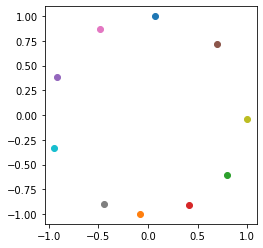

tf.Tensor(
[[ 0.07224397  0.9973869 ]
 [-0.07664014 -0.9970588 ]
 [ 0.7988814  -0.6014886 ]
 [ 0.41555667 -0.9095673 ]
 [-0.92207825  0.38700354]
 [ 0.6939672   0.7200066 ]
 [-0.48820996  0.8727262 ]
 [-0.44438204 -0.8958373 ]
 [ 0.9992494  -0.03874057]
 [-0.944278   -0.329149  ]], shape=(10, 2), dtype=float32)


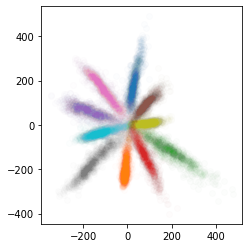

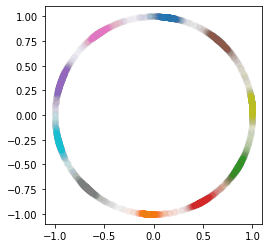

In [12]:
np.random.seed(1)
tf.random.set_seed(1)

# 定义使用的层
custom_layer = custom_layer_softmax(10)

# Create an instance of the model
model = MyModel()
model.compile(optimizer="adam")

model.fit(x_train, y_train, epochs=3)
model.evaluate(x_test,  y_test, verbose=2)

# 画出|w|的分布
ow = tf.math.l2_normalize(tf.transpose(model.layer5.w), 1)
fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(ow[i][0], ow[i][1], c='C'+str(i))
ax = plt.gca()
ax.set_aspect(1)
plt.show()
print(ow)

# 画出最终类结果分布
scat_fig = model.predict(x_test)
# scat_fig = tf.math.l2_normalize(model.predict(x_test), 1)
f = scat_fig[:]
g = y_test[:]

fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(f[g==i][:,0], f[g==i][:,1], c='C'+str(i), alpha=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

# 画出分类归一化到1的结果
# scat_fig = model.predict(x_test)
scat_fig = tf.math.l2_normalize(model.predict(x_test), 1)
f = scat_fig[:]
g = y_test[:]

fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(f[g==i][:,0], f[g==i][:,1], c='C'+str(i), alpha=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

# SphereFace

Epoch 1/3
1875/1875 [==============================] - 27s 14ms/step - loss: 0.6834 - acc: 0.7002
Epoch 2/3
1875/1875 [==============================] - 26s 14ms/step - loss: 0.3308 - acc: 0.9272
Epoch 3/3
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2445 - acc: 0.9532
313/313 - 1s - loss: 0.2652 - acc: 0.9514 - 1s/epoch - 5ms/step


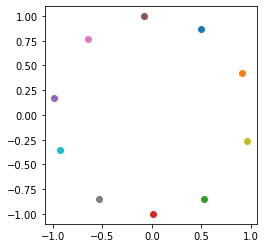

tf.Tensor(
[[ 0.49200365  0.87059313]
 [ 0.90731204  0.42045802]
 [ 0.53050613 -0.84768116]
 [ 0.01529294 -0.99988306]
 [-0.98452234  0.1752592 ]
 [-0.07805437  0.99694914]
 [-0.6434542   0.76548463]
 [-0.53326327 -0.84594935]
 [ 0.9642355  -0.26504704]
 [-0.933361   -0.3589392 ]], shape=(10, 2), dtype=float32)


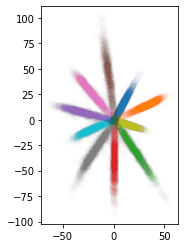

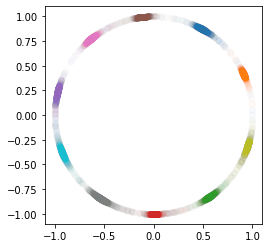

In [9]:
np.random.seed(1)
tf.random.set_seed(1)

# 定义使用的层
custom_layer = custom_layer_sphereface(10)

# Create an instance of the model
model = MyModel()
model.compile(optimizer="adam")

model.fit(x_train, y_train, epochs=3)
model.evaluate(x_test,  y_test, verbose=2)

# 画出|w|的分布
ow = tf.math.l2_normalize(tf.transpose(model.layer5.w), 1)
fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(ow[i][0], ow[i][1], c='C'+str(i))
ax = plt.gca()
ax.set_aspect(1)
plt.show()
print(ow)

# 画出最终类结果分布
scat_fig = model.predict(x_test)
# scat_fig = tf.math.l2_normalize(model.predict(x_test), 1)
f = scat_fig[:]
g = y_test[:]

fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(f[g==i][:,0], f[g==i][:,1], c='C'+str(i), alpha=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

# 画出分类归一化到1的结果
# scat_fig = model.predict(x_test)
scat_fig = tf.math.l2_normalize(model.predict(x_test), 1)
f = scat_fig[:]
g = y_test[:]

fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(f[g==i][:,0], f[g==i][:,1], c='C'+str(i), alpha=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

# CosFace

Epoch 1/3
1875/1875 [==============================] - 27s 14ms/step - loss: 0.7468 - acc: 0.5744
Epoch 2/3
1875/1875 [==============================] - 26s 14ms/step - loss: 0.3624 - acc: 0.9059
Epoch 3/3
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2747 - acc: 0.9342
313/313 - 1s - loss: 0.2778 - acc: 0.9420 - 1s/epoch - 4ms/step


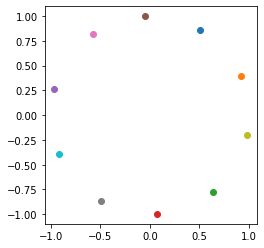

tf.Tensor(
[[ 0.50550425  0.8628241 ]
 [ 0.9176345   0.3974252 ]
 [ 0.63386834 -0.7734409 ]
 [ 0.07603669 -0.99710494]
 [-0.9632733   0.2685229 ]
 [-0.05306051  0.99859124]
 [-0.57503045  0.81813186]
 [-0.49223128 -0.8704645 ]
 [ 0.9797056  -0.20044239]
 [-0.9216519  -0.38801774]], shape=(10, 2), dtype=float32)


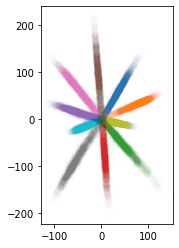

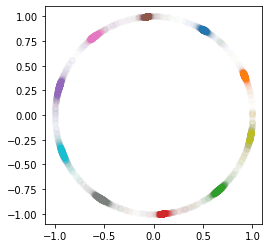

In [13]:
np.random.seed(1)
tf.random.set_seed(1)

# 定义使用的层
custom_layer = custom_layer_cosface(10)

# Create an instance of the model
model = MyModel()
model.compile(optimizer="adam")

model.fit(x_train, y_train, epochs=3)
model.evaluate(x_test,  y_test, verbose=2)

# 画出|w|的分布
ow = tf.math.l2_normalize(tf.transpose(model.layer5.w), 1)
fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(ow[i][0], ow[i][1], c='C'+str(i))
ax = plt.gca()
ax.set_aspect(1)
plt.show()
print(ow)

# 画出最终类结果分布
scat_fig = model.predict(x_test)
# scat_fig = tf.math.l2_normalize(model.predict(x_test), 1)
f = scat_fig[:]
g = y_test[:]

fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(f[g==i][:,0], f[g==i][:,1], c='C'+str(i), alpha=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

# 画出分类归一化到1的结果
# scat_fig = model.predict(x_test)
scat_fig = tf.math.l2_normalize(model.predict(x_test), 1)
f = scat_fig[:]
g = y_test[:]

fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(f[g==i][:,0], f[g==i][:,1], c='C'+str(i), alpha=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

# ArcFace

Epoch 1/3
1875/1875 [==============================] - 31s 16ms/step - loss: 0.5494 - acc: 0.7196
Epoch 2/3
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2465 - acc: 0.9337
Epoch 3/3
1875/1875 [==============================] - 29s 15ms/step - loss: 0.1855 - acc: 0.9559
313/313 - 1s - loss: 0.1831 - acc: 0.9610 - 1s/epoch - 5ms/step


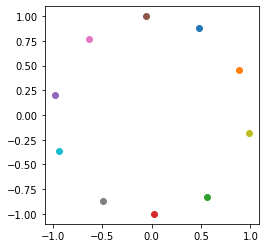

tf.Tensor(
[[ 0.4850165   0.8745049 ]
 [ 0.88837105  0.45912626]
 [ 0.5600851  -0.82843506]
 [ 0.03020513 -0.9995438 ]
 [-0.9798915   0.19953112]
 [-0.06054604  0.9981654 ]
 [-0.6352171   0.7723336 ]
 [-0.49278098 -0.8701533 ]
 [ 0.984249   -0.17678796]
 [-0.9303519  -0.36666772]], shape=(10, 2), dtype=float32)


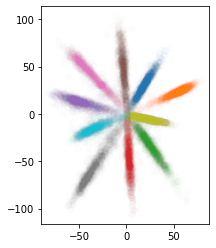

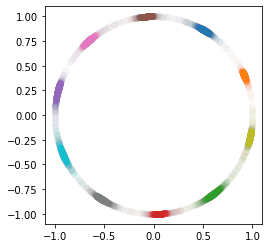

In [15]:
np.random.seed(1)
tf.random.set_seed(1)

# 定义使用的层
custom_layer = custom_layer_arcface(10)

# Create an instance of the model
model = MyModel()
model.compile(optimizer="adam")

model.fit(x_train, y_train, epochs=3)
model.evaluate(x_test,  y_test, verbose=2)

# 画出|w|的分布
ow = tf.math.l2_normalize(tf.transpose(model.layer5.w), 1)
fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(ow[i][0], ow[i][1], c='C'+str(i))
ax = plt.gca()
ax.set_aspect(1)
plt.show()
print(ow)

# 画出最终类结果分布
scat_fig = model.predict(x_test)
# scat_fig = tf.math.l2_normalize(model.predict(x_test), 1)
f = scat_fig[:]
g = y_test[:]

fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(f[g==i][:,0], f[g==i][:,1], c='C'+str(i), alpha=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

# 画出分类归一化到1的结果
# scat_fig = model.predict(x_test)
scat_fig = tf.math.l2_normalize(model.predict(x_test), 1)
f = scat_fig[:]
g = y_test[:]

fig = plt.figure()
p1 = fig.add_subplot()
for i in range(10):
    p1.scatter(f[g==i][:,0], f[g==i][:,1], c='C'+str(i), alpha=0.01)
ax = plt.gca()
ax.set_aspect(1)
plt.show()